In [ ]:
from google.colab import files
uploaded = files.upload()


Saving Bank_Churn.csv to Bank_Churn.csv


   CustomerId   Surname  CreditScore Geography  Gender  Age  Tenure  \
0    15634602  Hargrave          619    France  Female   42       2   
1    15647311      Hill          608     Spain  Female   41       1   
2    15619304      Onio          502    France  Female   42       8   
3    15701354      Boni          699    France  Female   39       1   
4    15737888  Mitchell          850     Spain  Female   43       2   

     Balance  NumOfProducts  HasCrCard  IsActiveMember  EstimatedSalary  \
0       0.00              1          1               1        101348.88   
1   83807.86              1          0               1        112542.58   
2  159660.80              3          1               0        113931.57   
3       0.00              2          0               0         93826.63   
4  125510.82              1          1               1         79084.10   

   Exited  
0       1  
1       0  
2       1  
3       0  
4       0  
   CreditScore Geography  Gender  Age  Tenure    B

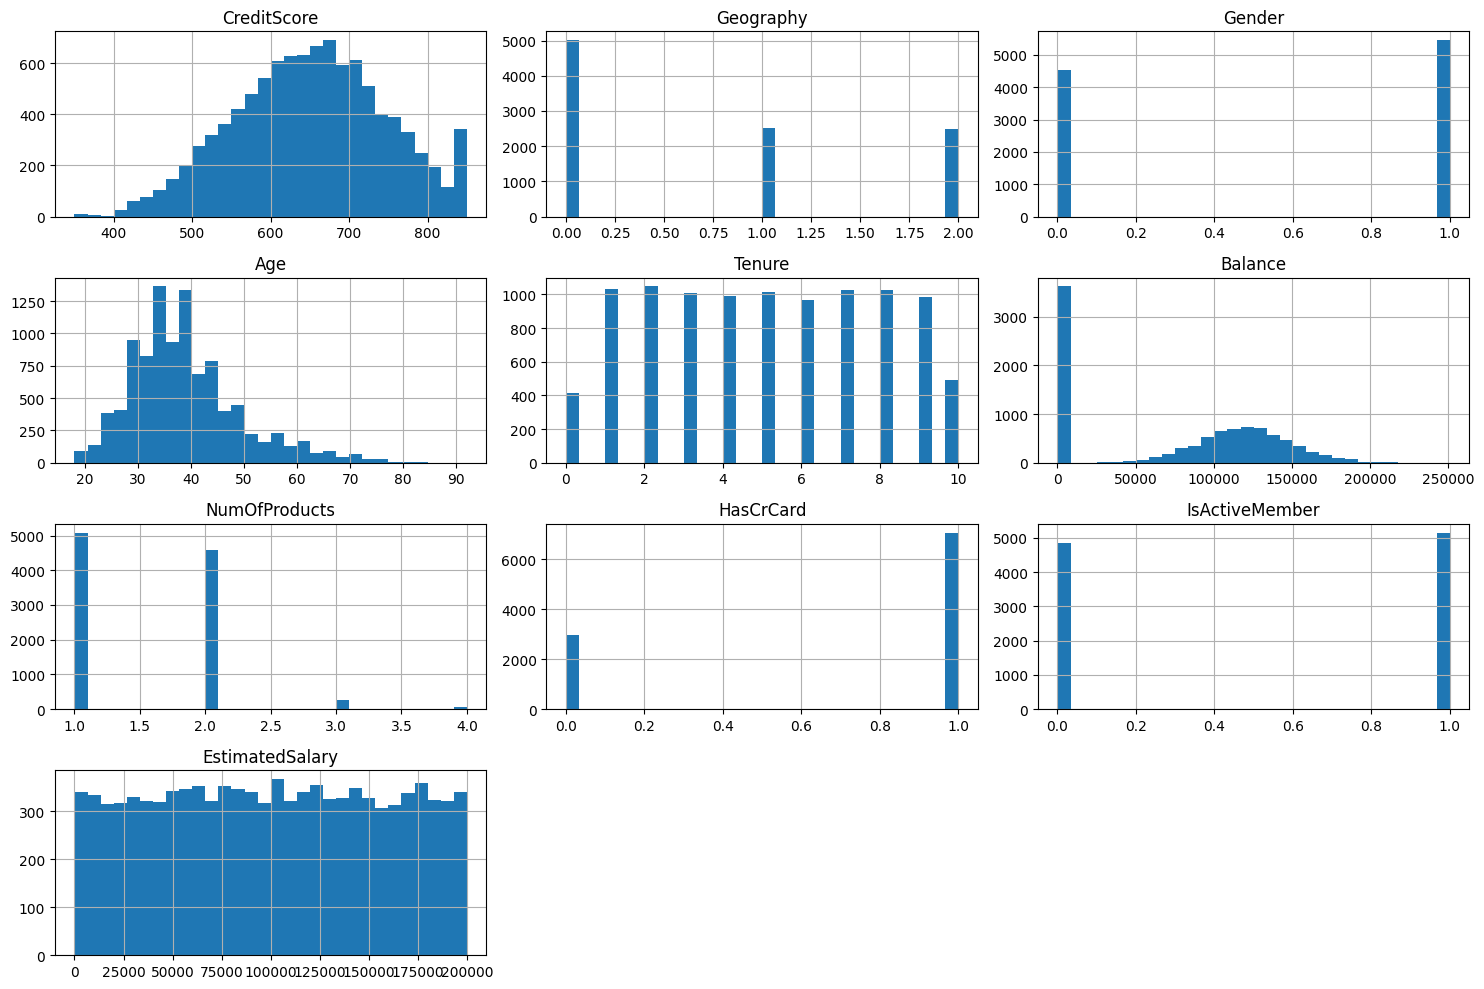

       ProductsPerYear
count     10000.000000
mean       5960.448920
std       30636.039329
min           0.100000
25%           0.200000
50%           0.333332
75%           0.666664
max      300000.000000


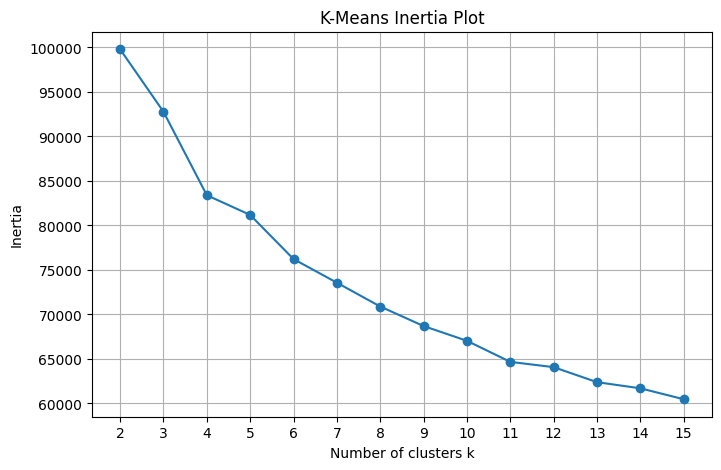

{np.int32(0): np.int64(413), np.int32(1): np.int64(3928), np.int32(2): np.int64(2795), np.int32(3): np.int64(2864)}


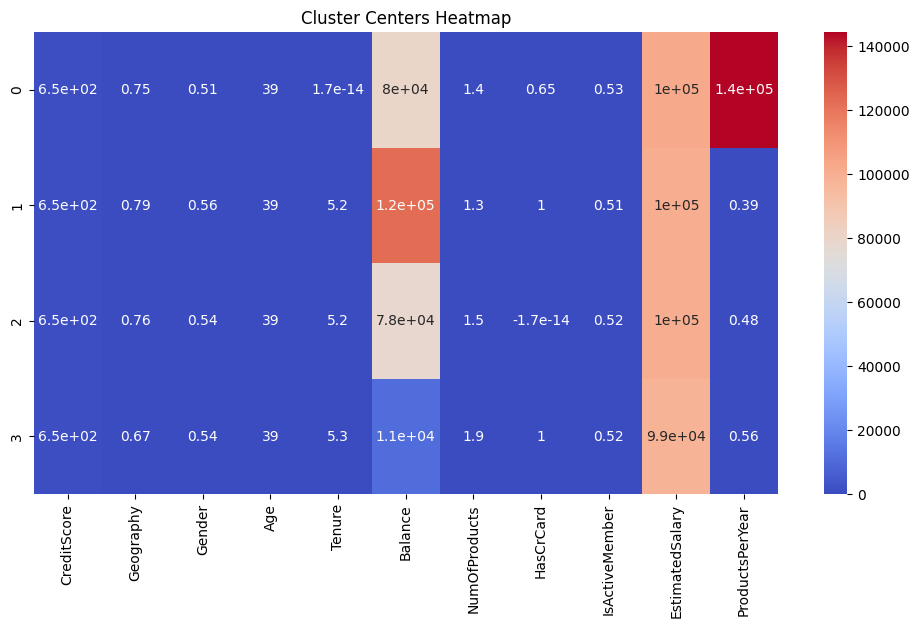

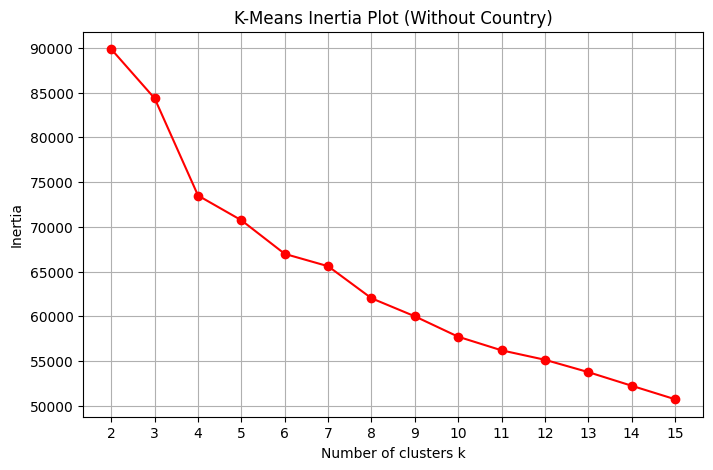

{np.int32(0): np.int64(413), np.int32(1): np.int64(2800), np.int32(2): np.int64(3316), np.int32(3): np.int64(3471)}


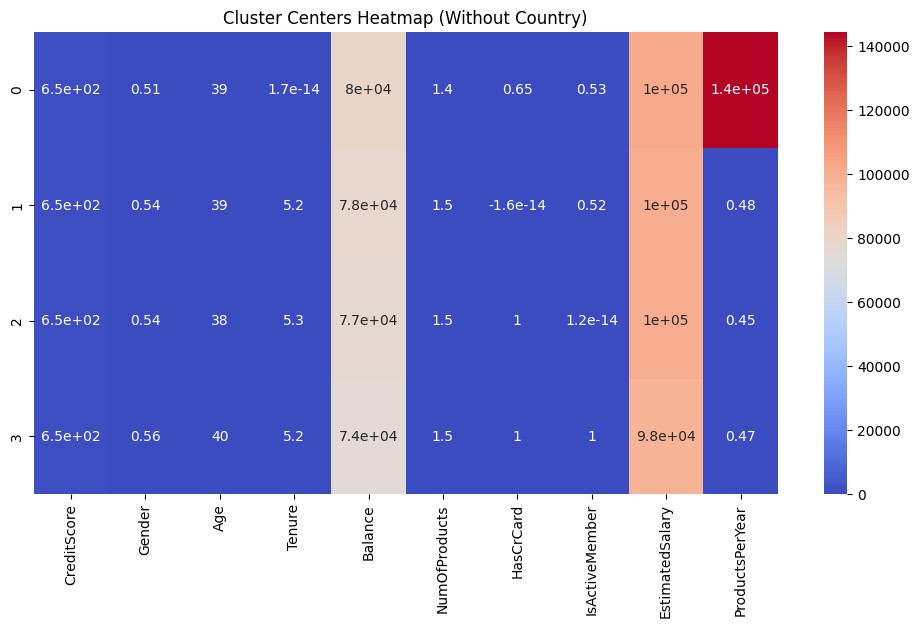

Churn rate (%) by cluster:
 Cluster
0    23.002421
1    22.225051
2    20.644007
3    17.178771
Name: Exited, dtype: float64

Country distribution (%) by cluster:
 Geography_text     France    Germany      Spain
Cluster                                        
0               49.636804  25.423729  24.939467
1               40.758656  39.256619  19.984725
2               49.874776  24.436494  25.688730
3               63.337989   6.250000  30.412011


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# Step 1: Read the file and preview top 5 rows
df = pd.read_csv('Bank_Churn.csv')
print(df.head())

# Step 2: Create DataFrame without "CustomerId", "Surname" and "Exited"
df_model = df.drop(columns=['CustomerId', 'Surname', 'Exited'])
print(df_model.head())

# Step 3: Make all text fields numeric
# Identify categorical columns (Geography, Gender)
df_model['Geography'] = df_model['Geography'].astype('category').cat.codes
df_model['Gender'] = df_model['Gender'].astype('category').cat.codes

# Step 4: Explore min, max, and distributions
print(df_model.describe())

# Visualize distributions
df_model.hist(bins=30, figsize=(15, 10))
plt.tight_layout()
plt.show()

# Step 5: Engineer new feature "ProductsPerYear"
# Note: Tenure is in years, NumOfProducts is count
df_model['ProductsPerYear'] = df_model['NumOfProducts'] / (df_model['Tenure'] + 1e-5)  # avoid div by zero

print(df_model[['ProductsPerYear']].describe())

# ========== OBJECTIVE 2: Clustering ==========

# Step 6: Standardize the data (mean=0, std=1)
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_model)

# Step 7: Fit K-Means with clusters 2-15 and create inertia plot
inertia = []
K_range = range(2, 16)
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(df_scaled)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8,5))
plt.plot(K_range, inertia, marker='o')
plt.title('K-Means Inertia Plot')
plt.xlabel('Number of clusters k')
plt.ylabel('Inertia')
plt.xticks(K_range)
plt.grid(True)
plt.show()

# Step 8: Choose elbow (for example k=4 here based on plot)
k_optimal = 4
kmeans_final = KMeans(n_clusters=k_optimal, random_state=42)
clusters = kmeans_final.fit_predict(df_scaled)

# Step 9: Check number of customers in each cluster
unique, counts = np.unique(clusters, return_counts=True)
print(dict(zip(unique, counts)))

# Step 10: Create heatmap of cluster centers
cluster_centers = kmeans_final.cluster_centers_

# Convert centers back to original scale for interpretation
centers_original_scale = scaler.inverse_transform(cluster_centers)
centers_df = pd.DataFrame(centers_original_scale, columns=df_model.columns)

plt.figure(figsize=(12,6))
sns.heatmap(centers_df, annot=True, cmap='coolwarm')
plt.title('Cluster Centers Heatmap')
plt.show()

# ========== OBJECTIVE 3: Cluster without country fields ==========

# Drop country fields (Geography here)
df_no_country = df_model.drop(columns=['Geography'])

# Standardize again
df_no_country_scaled = scaler.fit_transform(df_no_country)

# Inertia plot for k=2 to 15 without country fields
inertia_nc = []
for k in K_range:
    kmeans_nc = KMeans(n_clusters=k, random_state=42)
    kmeans_nc.fit(df_no_country_scaled)
    inertia_nc.append(kmeans_nc.inertia_)

plt.figure(figsize=(8,5))
plt.plot(K_range, inertia_nc, marker='o', color='red')
plt.title('K-Means Inertia Plot (Without Country)')
plt.xlabel('Number of clusters k')
plt.ylabel('Inertia')
plt.xticks(K_range)
plt.grid(True)
plt.show()

# Fit final model without country fields, say k=4 again
kmeans_nc_final = KMeans(n_clusters=k_optimal, random_state=42)
clusters_nc = kmeans_nc_final.fit_predict(df_no_country_scaled)

# Number of customers per cluster
unique_nc, counts_nc = np.unique(clusters_nc, return_counts=True)
print(dict(zip(unique_nc, counts_nc)))

# Heatmap of centers without country
centers_nc = kmeans_nc_final.cluster_centers_
centers_nc_orig = scaler.inverse_transform(centers_nc)
centers_nc_df = pd.DataFrame(centers_nc_orig, columns=df_no_country.columns)

plt.figure(figsize=(12,6))
sns.heatmap(centers_nc_df, annot=True, cmap='coolwarm')
plt.title('Cluster Centers Heatmap (Without Country)')
plt.show()

# ========== OBJECTIVE 4: Explore clusters and churn ==========

# Combine original data with Exited and cluster labels (from model with country)
df_clustered = df_model.copy()
df_clustered['Exited'] = df['Exited']
df_clustered['Cluster'] = clusters

# View churn rate per cluster
churn_rate = df_clustered.groupby('Cluster')['Exited'].mean() * 100
print("Churn rate (%) by cluster:\n", churn_rate)

# View country breakdown per cluster (using original df Geography text)
df_clustered['Geography_text'] = df['Geography']
country_breakdown = pd.crosstab(df_clustered['Cluster'], df_clustered['Geography_text'], normalize='index') * 100
print("\nCountry distribution (%) by cluster:\n", country_breakdown)



In [ ]:
# ========== FINAL QUESTION ==========
highest_churn_cluster = churn_rate.idxmax()
highest_churn_rate = churn_rate.max()
print(f"\nCluster with highest churn: {highest_churn_cluster} with Exited % = {highest_churn_rate:.2f}%")


Cluster with highest churn: 0 with Exited % = 23.00%
